In [ ]:
# =============================================================================
# LAKE ICE FRACTION ANALYSIS FOR Imja
# Jeevan - 2025 June28

# WORKFLOW:
# 1. Upload and merge reflectance files
# 2. Perform cubic spline interpolation to fill gaps
# 3. Merge lake ice fraction data
# 4. Apply Savitzky-Golay filtering with different window sizes
# 5. Apply Moving Average filtering with different window sizes
# 6. Polynomial regression analysis to find best window size and polynomial degree
# 7. Model selection and final visualization
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from datetime import datetime
from scipy.interpolate import CubicSpline
from scipy.signal import savgol_filter
from scipy import stats
import statsmodels.api as sm
from google.colab import drive

# Configuration Constants - Fixed inconsistent thresholds
REFLECTANCE_THRESHOLD = 0.80  # Consistent threshold throughout
WINDOW_SIZES = list(range(5, 100))  # Window sizes for filtering
POLYNOMIAL_DEGREES = [1, 2, 3]  # Polynomial degrees to test
POLY_ORDER = 3  # Savitzky-Golay polynomial order

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

#STEP 1: DATA LOADING AND PREPROCESSING

def parse_date_flexible(date_str):
    """Parse dates with multiple format support."""
    for fmt in ('%Y%m%d', '%Y-%m-%d'):
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    return pd.NaT

# Load and merge reflectance data
path = "/content/drive/MyDrive/ee4/Analysis"
search_pattern = os.path.join(path, '*.csv')
all_filenames = glob.glob(search_pattern)

if not all_filenames:
    raise FileNotFoundError(f"No CSV files found in directory: {path}")

# Combine all CSV files
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames])
print(f"Successfully loaded {len(all_filenames)} files with {len(combined_csv)} total records")

# Parse dates with error handling
combined_csv['date_str'] = combined_csv['date'].astype(str)
combined_csv['date_dt'] = combined_csv['date_str'].apply(parse_date_flexible)

# Remove invalid dates
initial_count = len(combined_csv)
combined_csv = combined_csv.dropna(subset=['date_dt'])
removed_count = initial_count - len(combined_csv)
if removed_count > 0:
    print(f"Removed {removed_count} records with invalid dates")

# Group by date and aggregate
combined_csv = combined_csv.groupby('date_dt').agg({
    'mean_red': 'mean',
    'mean_nir': 'mean'
}).reset_index()

# Convert to days since 2000-01-01
combined_csv['days'] = (combined_csv['date_dt'] - datetime(2000, 1, 1)).dt.days
combined_csv = combined_csv.sort_values(by='days').reset_index(drop=True)
print(f"Final preprocessed data: {len(combined_csv)} records")


Successfully loaded 5 files with 9005 total records
Final preprocessed data: 9005 records


In [ ]:
#STEP 2: CUBIC SPLINE INTERPOLATION

# Cubic spline interpolation for missing values
days = combined_csv['days'].values

for band in ['red', 'nir']:
    col = f'mean_{band}'
    values = combined_csv[col].values
    valid = ~np.isnan(values)

    if np.any(valid):
        try:
            cs = CubicSpline(days[valid], values[valid], extrapolate=False)
            combined_csv[f'mean_{band}_filled'] = np.where(valid, values, cs(days))
            print(f"Successfully interpolated {band} band")
        except Exception as e:
            print(f"Error interpolating {band} band: {e}")
            combined_csv[f'mean_{band}_filled'] = values
    else:
        combined_csv[f'mean_{band}_filled'] = values

print("\nData after interpolation:")
print(combined_csv.head())
print(f"Shape: {combined_csv.shape}")


Successfully interpolated red band
Successfully interpolated nir band

Data after interpolation:
     date_dt  mean_red  mean_nir  days  mean_red_filled  mean_nir_filled
0 2000-02-24       NaN       NaN    54              NaN              NaN
1 2000-02-25       NaN       NaN    55              NaN              NaN
2 2000-02-26  0.220773  0.205979    56         0.220773         0.205979
3 2000-02-27  0.348075  0.325871    57         0.348075         0.325871
4 2000-02-28  0.352341  0.327221    58         0.352341         0.327221
Shape: (9005, 6)


In [ ]:
#STEP 3: MERGE ICE FRACTION DATA

# Load and preprocess ice fraction data
ice_csv = pd.read_csv('/content/drive/MyDrive/ee4/Analysis/if_file/LakeIceFraction_Imja.csv')
ice_csv['date_str'] = ice_csv['date'].astype(str)
ice_csv['days'] = ice_csv['date_str'].apply(
    lambda x: (datetime.strptime(x, "%Y%m%d") - datetime(2000, 1, 1)).days
)
ice_csv = ice_csv.sort_values(by='days').reset_index(drop=True)

# Merge with reflectance data
combined_csv = pd.merge(combined_csv, ice_csv[['days', 'ice_fraction']],
                        on='days', how='left')

print(f"Merged data: {len(combined_csv)} records, {combined_csv['ice_fraction'].notna().sum()} with ice fraction data")
print("\nData with ice fraction:")
print(combined_csv.head())


Merged data: 9005 records, 92 with ice fraction data

Data with ice fraction:
     date_dt  mean_red  mean_nir  days  mean_red_filled  mean_nir_filled  \
0 2000-02-24       NaN       NaN    54              NaN              NaN   
1 2000-02-25       NaN       NaN    55              NaN              NaN   
2 2000-02-26  0.220773  0.205979    56         0.220773         0.205979   
3 2000-02-27  0.348075  0.325871    57         0.348075         0.325871   
4 2000-02-28  0.352341  0.327221    58         0.352341         0.327221   

   ice_fraction  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  


In [ ]:
#STEP 4: TIME-BASED INTERPOLATION

# Create datetime index and interpolate
combined_csv['date'] = pd.to_datetime('2000-01-01') + pd.to_timedelta(combined_csv['days'], unit='d')
combined_csv = combined_csv.set_index('date').sort_index()

for band in ['red', 'nir']:
    col = f'mean_{band}_filled'
    combined_csv[col] = combined_csv[col].interpolate(method='time')

combined_csv = combined_csv.reset_index()
print("Time-based interpolation completed")
print(f"Final shape: {combined_csv.shape}")


Time-based interpolation completed
Final shape: (9005, 8)


In [ ]:
#STEP 5: APPLY SAVITZKY-GOLAY FILTERING

# Apply SG filter for each window size
for win_size in WINDOW_SIZES:
    # Ensure odd window size
    adj_win = win_size + 1 if win_size % 2 == 0 else win_size
    adj_win = min(adj_win, len(combined_csv))

    for band in ['red', 'nir']:
        col = f'mean_{band}_filled'
        try:
            combined_csv[f'mean_{band}_sg_{win_size}'] = savgol_filter(
                combined_csv[col],
                window_length=adj_win,
                polyorder=POLY_ORDER
            )
        except Exception as e:
            print(f"Error applying SG filter for {band} band, window {win_size}: {e}")
            continue

print(f"Applied Savitzky-Golay filtering with {len(WINDOW_SIZES)} window sizes")
sg_columns = [col for col in combined_csv.columns if '_sg_' in col]
print(f"SG filtered columns created: {len(sg_columns)}")

Applied Savitzky-Golay filtering with 95 window sizes
SG filtered columns created: 190


/tmp/ipython-input-13-1605112396.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_csv[f'mean_{band}_sg_{win_size}'] = savgol_filter(
/tmp/ipython-input-13-1605112396.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_csv[f'mean_{band}_sg_{win_size}'] = savgol_filter(
/tmp/ipython-input-13-1605112396.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(ax

In [ ]:
#STEP 6: APPLY MOVING AVERAGE FILTERING

# Apply Moving Average filter for each window size
for win_size in WINDOW_SIZES:
    for band in ['red', 'nir']:
        col = f'mean_{band}_filled'
        try:
            combined_csv[f'mean_{band}_ma_{win_size}'] = combined_csv[col].rolling(
                window=win_size,
                center=True,
                min_periods=1
            ).mean()
        except Exception as e:
            print(f"Error applying MA filter for {band} band, window {win_size}: {e}")
            continue

print(f"Applied Moving Average filtering with {len(WINDOW_SIZES)} window sizes")
ma_columns = [col for col in combined_csv.columns if '_ma_' in col]
print(f"MA filtered columns created: {len(ma_columns)}")
print("\nData with both filtering methods applied:")
print(combined_csv.head())


/tmp/ipython-input-14-455111931.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_csv[f'mean_{band}_ma_{win_size}'] = combined_csv[col].rolling(
/tmp/ipython-input-14-455111931.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_csv[f'mean_{band}_ma_{win_size}'] = combined_csv[col].rolling(
/tmp/ipython-input-14-455111931.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once 

Applied Moving Average filtering with 95 window sizes
MA filtered columns created: 190

Data with both filtering methods applied:
        date    date_dt  mean_red  mean_nir  days  mean_red_filled  \
0 2000-02-24 2000-02-24       NaN       NaN    54              NaN   
1 2000-02-25 2000-02-25       NaN       NaN    55              NaN   
2 2000-02-26 2000-02-26  0.220773  0.205979    56         0.220773   
3 2000-02-27 2000-02-27  0.348075  0.325871    57         0.348075   
4 2000-02-28 2000-02-28  0.352341  0.327221    58         0.352341   

   mean_nir_filled  ice_fraction  mean_red_sg_5  mean_nir_sg_5  ...  \
0              NaN           NaN            NaN            NaN  ...   
1              NaN           NaN            NaN            NaN  ...   
2         0.205979           NaN            NaN            NaN  ...   
3         0.325871           NaN            NaN            NaN  ...   
4         0.327221           NaN       0.330299       0.284353  ...   

   mean_red_ma_95  mea

/tmp/ipython-input-14-455111931.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_csv[f'mean_{band}_ma_{win_size}'] = combined_csv[col].rolling(
/tmp/ipython-input-14-455111931.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_csv[f'mean_{band}_ma_{win_size}'] = combined_csv[col].rolling(
/tmp/ipython-input-14-455111931.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once 

In [ ]:
#STEP 7: CREATE BALANCED DATASET

def create_balanced_dataset(df, reflectance_threshold=REFLECTANCE_THRESHOLD):
    """Create balanced dataset for regression analysis."""
    # Filter for valid ice fraction data
    valid_ice = df[df["ice_fraction"].notna()].copy()

    # Apply consistent reflectance filtering - FIXED HTML entities
    filtered_data = valid_ice[
        (valid_ice['mean_red_filled'] < reflectance_threshold) &
        (valid_ice['mean_nir_filled'] < reflectance_threshold)
    ].copy()

    # Split by ice fraction threshold
    below = filtered_data[filtered_data["ice_fraction"] < 0.5].copy()
    above = filtered_data[filtered_data["ice_fraction"] >= 0.5].copy()

    # Balance the dataset
    n_below, n_above = len(below), len(above)

    if n_below > n_above:
        diff = n_below - n_above
        below["dist_to_half"] = (below["ice_fraction"] - 0.5).abs()
        to_drop = below.nsmallest(diff, "dist_to_half").index
        below_balanced = below.drop(index=to_drop).drop(columns="dist_to_half")
        above_balanced = above
    elif n_above > n_below:
        diff = n_above - n_below
        above["dist_to_half"] = (above["ice_fraction"] - 0.5).abs()
        to_drop = above.nsmallest(diff, "dist_to_half").index
        above_balanced = above.drop(index=to_drop).drop(columns="dist_to_half")
        below_balanced = below
    else:
        below_balanced = below
        above_balanced = above

    balanced_df = pd.concat([below_balanced, above_balanced], ignore_index=True)
    print(f"Balanced dataset: {len(below_balanced)} below 0.5, {len(above_balanced)} above 0.5")

    return balanced_df

# Create single balanced dataset - eliminates duplication
balanced_df = create_balanced_dataset(combined_csv, REFLECTANCE_THRESHOLD)
print(f"Final balanced dataset shape: {balanced_df.shape}")


Balanced dataset: 28 below 0.5, 28 above 0.5
Final balanced dataset shape: (56, 388)


In [ ]:
#STEP 8: POLYNOMIAL REGRESSION ANALYSIS (SAVITZKY-GOLAY)


def perform_polynomial_regression(df, filter_type, window_sizes=WINDOW_SIZES, degrees=POLYNOMIAL_DEGREES):
    """Perform polynomial regression analysis for given filter type."""
    results = []

    for band in ['red', 'nir']:
        for win_size in window_sizes:
            col = f'mean_{band}_{filter_type}_{win_size}'

            if col not in df.columns:
                continue

            # Get valid data
            X = df[col].dropna()
            y = df['ice_fraction'].loc[X.index]

            if len(X) < 2 or X.nunique() <= 1:
                continue

            for degree in degrees:
                if len(X) < degree + 1:
                    continue

                try:
                    # Create polynomial features
                    X_poly = np.column_stack([X**d for d in range(1, degree+1)])
                    X_poly = sm.add_constant(X_poly)

                    # Fit model
                    model = sm.OLS(y, X_poly).fit()

                    # Calculate bias (mean of residuals)
                    bias = np.mean(model.resid)

                    # Calculate MAE and RMSE
                    predictions = model.predict(X_poly)
                    mae = np.mean(np.abs(y - predictions))
                    rmse = np.sqrt(np.mean((y - predictions)**2))


                    # Store results
                    results.append({
                        'Model_Type': f'Polynomial ({filter_type.upper()})',
                        'Band': band.upper(),
                        'Window_Size': win_size,
                        'Degree': degree,
                        'R_squared': model.rsquared,
                        'Adj_R_squared': model.rsquared_adj,
                        'P_value': model.f_pvalue,
                        'AIC': model.aic,
                        'BIC': model.bic,
                        'N_obs': len(y),
                        'N_Parameters': degree + 1,
                        'Equation': f"y = {model.params[0]:.4f} + " +
                                   " + ".join([f"{model.params[i]:.4f}x^{i}"
                                              for i in range(1, len(model.params))]),
                        'Bias': bias,
                        'MAE': mae,
                        'RMSE': rmse
                    })

                except Exception as e:
                    print(f"Error fitting {filter_type.upper()} model for {band} band, window {win_size}, degree {degree}: {e}")
                    continue

    print(f"Completed {filter_type.upper()} polynomial regression analysis: {len(results)} models fitted")
    return results

# Perform Savitzky-Golay regression analysis
sg_results = perform_polynomial_regression(balanced_df, 'sg', WINDOW_SIZES, POLYNOMIAL_DEGREES)

# Display results
if sg_results:
    sg_results_df = pd.DataFrame(sg_results)
    sig_sg_models = sg_results_df[sg_results_df['P_value'] < 0.05].copy()

    if not sig_sg_models.empty:
        top_20_sg = sig_sg_models.sort_values('R_squared', ascending=False).head(20)

        # Format for display
        display_sg_df = top_20_sg.copy()
        display_sg_df['R_squared'] = display_sg_df['R_squared'].map('{:.4f}'.format)
        display_sg_df['Adj_R_squared'] = display_sg_df['Adj_R_squared'].map('{:.4f}'.format)
        display_sg_df['P_value'] = display_sg_df['P_value'].apply(
            lambda x: f"{x:.4g}" if x >= 0.0001 else "<0.0001"
        )
        display_sg_df['AIC'] = display_sg_df['AIC'].map('{:.1f}'.format)
        display_sg_df['BIC'] = display_sg_df['BIC'].map('{:.1f}'.format)
        display_sg_df['Bias'] = display_sg_df['Bias'].map('{:.4f}'.format)
        display_sg_df['MAE'] = display_sg_df['MAE'].map('{:.4f}'.format)
        display_sg_df['RMSE'] = display_sg_df['RMSE'].map('{:.4f}'.format)


        print("\nTop 20 Performing Savitzky-Golay Models (Significant: p < 0.05):")
        print(display_sg_df[['Model_Type', 'Band', 'Window_Size', 'Degree', 'R_squared', 'AIC', 'Bias', 'MAE', 'RMSE', 'P_value']].to_string(index=False))
    else:
        print("No significant SG models found")
else:
    print("No SG regression results available")

/tmp/ipython-input-16-2748676976.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Equation': f"y = {model.params[0]:.4f} + " +
/tmp/ipython-input-16-2748676976.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  " + ".join([f"{model.params[i]:.4f}x^{i}"
/tmp/ipython-input-16-2748676976.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Equation': f"y = {model.params[0]:.4f} + " +
/tmp/ipython-input-16-2748676976.py:57: Futu

Completed SG polynomial regression analysis: 570 models fitted

Top 20 Performing Savitzky-Golay Models (Significant: p < 0.05):
     Model_Type Band  Window_Size  Degree R_squared AIC    Bias    MAE   RMSE P_value
Polynomial (SG)  RED           97       3    0.7567 3.6  0.0000 0.1710 0.2326 <0.0001
Polynomial (SG)  RED           96       3    0.7567 3.6  0.0000 0.1710 0.2326 <0.0001
Polynomial (SG)  RED           98       3    0.7566 3.6  0.0000 0.1721 0.2327 <0.0001
Polynomial (SG)  RED           99       3    0.7566 3.6  0.0000 0.1721 0.2327 <0.0001
Polynomial (SG)  RED           94       3    0.7544 4.1 -0.0000 0.1715 0.2337 <0.0001
Polynomial (SG)  RED           95       3    0.7544 4.1 -0.0000 0.1715 0.2337 <0.0001
Polynomial (SG)  RED           92       3    0.7478 5.6 -0.0000 0.1750 0.2368 <0.0001
Polynomial (SG)  RED           93       3    0.7478 5.6 -0.0000 0.1750 0.2368 <0.0001
Polynomial (SG)  RED           91       3    0.7427 6.7 -0.0000 0.1772 0.2392 <0.0001
Polynomial 

In [ ]:
#STEP 9: POLYNOMIAL REGRESSION ANALYSIS (MOVING AVERAGE)


# Perform Moving Average regression analysis using same balanced dataset
ma_results = perform_polynomial_regression(balanced_df, 'ma', WINDOW_SIZES, POLYNOMIAL_DEGREES)

# Display results
if ma_results:
    ma_results_df = pd.DataFrame(ma_results)
    sig_ma_models = ma_results_df[ma_results_df['P_value'] < 0.05].copy()

    if not sig_ma_models.empty:
        top_20_ma = sig_ma_models.sort_values('R_squared', ascending=False).head(20)

        # Format for display
        display_ma_df = top_20_ma.copy()
        display_ma_df['R_squared'] = display_ma_df['R_squared'].map('{:.4f}'.format)
        display_ma_df['Adj_R_squared'] = display_ma_df['Adj_R_squared'].map('{:.4f}'.format)
        display_ma_df['P_value'] = display_ma_df['P_value'].apply(
            lambda x: f"{x:.4g}" if x >= 0.0001 else "<0.0001"
        )
        display_ma_df['AIC'] = display_ma_df['AIC'].map('{:.1f}'.format)
        display_ma_df['BIC'] = display_ma_df['BIC'].map('{:.1f}'.format)
        display_ma_df['Bias'] = display_ma_df['Bias'].map('{:.4f}'.format)
        display_ma_df['MAE'] = display_ma_df['MAE'].map('{:.4f}'.format)
        display_ma_df['RMSE'] = display_ma_df['RMSE'].map('{:.4f}'.format)


        print("\nTop 20 Performing Moving Average Models (Significant: p < 0.05):")
        print(display_ma_df[['Model_Type', 'Band', 'Window_Size', 'Degree', 'R_squared', 'AIC', 'Bias', 'MAE', 'RMSE', 'P_value']].to_string(index=False))
    else:
        print("No significant MA models found")
else:
    print("No MA regression results available")

/tmp/ipython-input-16-2748676976.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Equation': f"y = {model.params[0]:.4f} + " +
/tmp/ipython-input-16-2748676976.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  " + ".join([f"{model.params[i]:.4f}x^{i}"
/tmp/ipython-input-16-2748676976.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Equation': f"y = {model.params[0]:.4f} + " +
/tmp/ipython-input-16-2748676976.py:57: Futu

Completed MA polynomial regression analysis: 570 models fitted

Top 20 Performing Moving Average Models (Significant: p < 0.05):
     Model_Type Band  Window_Size  Degree R_squared  AIC    Bias    MAE   RMSE P_value
Polynomial (MA)  RED           89       3    0.7819 -2.5  0.0000 0.1643 0.2202 <0.0001
Polynomial (MA)  RED           95       3    0.7801 -2.1 -0.0000 0.1657 0.2211 <0.0001
Polynomial (MA)  RED           93       3    0.7800 -2.1  0.0000 0.1653 0.2212 <0.0001
Polynomial (MA)  RED           91       3    0.7800 -2.0 -0.0000 0.1651 0.2212 <0.0001
Polynomial (MA)  RED           87       3    0.7795 -1.9 -0.0000 0.1647 0.2215 <0.0001
Polynomial (MA)  RED           97       3    0.7794 -1.9 -0.0000 0.1656 0.2215 <0.0001
Polynomial (MA)  RED           94       3    0.7790 -1.8 -0.0000 0.1656 0.2217 <0.0001
Polynomial (MA)  RED           90       3    0.7787 -1.7  0.0000 0.1652 0.2218 <0.0001
Polynomial (MA)  RED           96       3    0.7783 -1.6  0.0000 0.1661 0.2220 <0.0001
P


Best model selected based on lowest AIC yet highest window size from top 20 AIC models:
Model Type: Polynomial (MA)
Band: RED
Window Size: 99
Degree: 3
R²: 0.7782
AIC: -1.60
Bias: -0.0000
MAE: 0.1655
RMSE: 0.2221
P-value: 5.12e-17


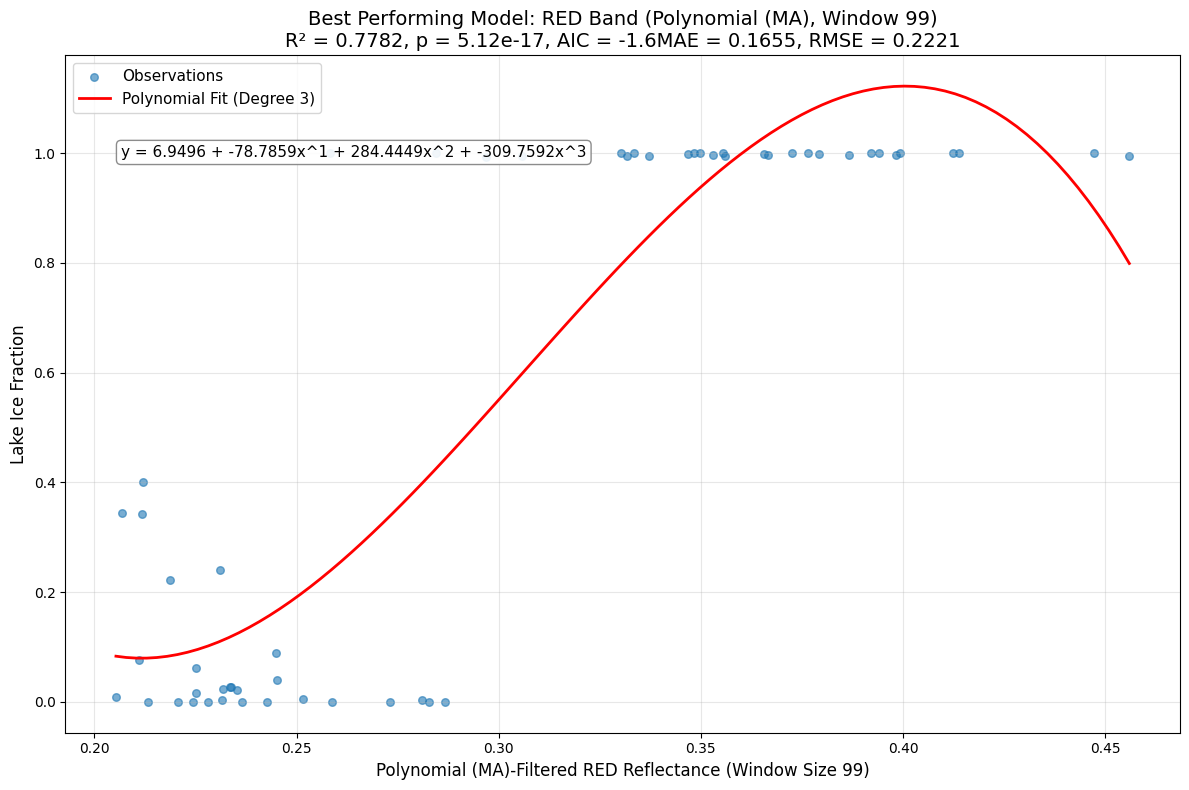


Final visualization created for best model: RED band, Polynomial (MA), Window 99

LAKE ICE FRACTION ANALYSIS COMPLETED SUCCESSFULLY


In [ ]:
#STEP 10: MODEL SELECTION AND FINAL VISUALIZATION


# Combine all results - eliminates duplication
all_results = sg_results + ma_results

if all_results:
    all_results_df = pd.DataFrame(all_results)

    # Filter for significant models
    significant_models = all_results_df[all_results_df['P_value'] < 0.05].copy()

    if not significant_models.empty:
        # Select best model based on lowest AIC yet highest window size in step 10 - MODIFIED
        # First, get the top 20 models by AIC
        top_20_by_aic = significant_models.sort_values('AIC', ascending=True).head(20).copy()

        # Then, select the model with the highest window size from this subset, breaking ties with lowest RMSE
        best_model = top_20_by_aic.sort_values(['Window_Size', 'RMSE'], ascending=[False, True]).iloc[0]


        print(f"\nBest model selected based on lowest AIC yet highest window size from top 20 AIC models:")
        print(f"Model Type: {best_model['Model_Type']}")
        print(f"Band: {best_model['Band']}")
        print(f"Window Size: {best_model['Window_Size']}")
        print(f"Degree: {best_model['Degree']}")
        print(f"R²: {best_model['R_squared']:.4f}")
        print(f"AIC: {best_model['AIC']:.2f}")
        print(f"Bias: {best_model['Bias']:.4f}")
        print(f"MAE: {best_model['MAE']:.4f}")
        print(f"RMSE: {best_model['RMSE']:.4f}")
        print(f"P-value: {best_model['P_value']:.2e}")


        # Create final visualization - SINGLE PLOT ONLY
        model_type = best_model['Model_Type']
        band = best_model['Band'].lower()
        win_size = int(best_model['Window_Size'])
        degree = int(best_model['Degree'])

        # Determine column name based on model type
        if 'SG' in model_type:
            col = f'mean_{band}_sg_{win_size}'
        elif 'MA' in model_type:
            col = f'mean_{band}_ma_{win_size}'
        else:
            raise ValueError(f"Unknown model type: {model_type}")

        if col in balanced_df.columns:
            # Prepare data
            x_data = balanced_df[col].dropna()
            y_data = balanced_df['ice_fraction'].loc[x_data.index]

            # Fit model for visualization
            X_poly = np.column_stack([x_data**d for d in range(1, degree+1)])
            X_poly = sm.add_constant(X_poly)
            model_viz = sm.OLS(y_data, X_poly).fit()

            # Generate prediction line
            x_range = np.linspace(x_data.min(), x_data.max(), 100)
            x_poly_range = np.column_stack([x_range**d for d in range(1, degree+1)])
            x_poly_range = sm.add_constant(x_poly_range)
            y_pred = model_viz.predict(x_poly_range)

            # Create the plot
            plt.figure(figsize=(12, 8))
            plt.scatter(x_data, y_data, alpha=0.6, s=30, label='Observations')
            plt.plot(x_range, y_pred, 'r-', lw=2, label=f'Polynomial Fit (Degree {degree})')

            plt.title(f'Best Performing Model: {best_model["Band"]} Band ({model_type}, Window {win_size})\n'
                      f'R² = {best_model["R_squared"]:.4f}, p = {best_model["P_value"]:.2e}, AIC = {best_model["AIC"]:.1f}'
                      f'MAE = {best_model["MAE"]:.4f}, RMSE = {best_model["RMSE"]:.4f}',
                      fontsize=14, fontweight='normal')


            plt.xlabel(f'{model_type}-Filtered {best_model["Band"]} Reflectance (Window Size {win_size})', fontsize=12)
            plt.ylabel('Lake Ice Fraction', fontsize=12)
            plt.grid(alpha=0.3)
            plt.legend(fontsize=11)

            # Add equation annotation
            plt.annotate(best_model['Equation'],
                         xy=(0.05, 0.85), xycoords='axes fraction',
                         fontsize=11, backgroundcolor='white',
                         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))

            plt.tight_layout()
            plt.savefig(f'best_model_{band}_win{win_size}.png', dpi=300, bbox_inches='tight')
            plt.show()

            print(f"\nFinal visualization created for best model: {best_model['Band']} band, {model_type}, Window {win_size}")
        else:
            print(f"Column {col} not found for visualization")
    else:
        print("No significant models found (p < 0.05)")
else:
    print("No regression results available")

print("\n" + "="*80)
print("LAKE ICE FRACTION ANALYSIS COMPLETED SUCCESSFULLY")
print("="*80)

In [ ]:
#"STEP 11: MODEL PREDICTION AND THRESHOLD DETECTION"


def create_prediction_dataframe(best_model, reflectance_range=(0.20, 0.42), n_points=1000):
    """
    Create prediction dataframe using the best model.

    Args:
        best_model (pd.Series): Best model information from previous analysis
        reflectance_range (tuple): Min and max reflectance values for prediction
        n_points (int): Number of prediction points

    Returns:
        pd.DataFrame: DataFrame with reflectance values and predicted ice fractions
    """
    # Extract model parameters
    model_type = best_model['Model_Type']
    band = best_model['Band'].lower()
    win_size = int(best_model['Window_Size'])
    degree = int(best_model['Degree'])

    # Generate continuous reflectance values
    x_values = np.linspace(reflectance_range[0], reflectance_range[1], n_points)

    # Create polynomial features for prediction
    X_poly = np.column_stack([x_values**d for d in range(1, degree+1)])
    X_poly = sm.add_constant(X_poly)

    # Get the original data to refit the model for prediction
    if 'SG' in model_type:
        col = f'mean_{band}_sg_{win_size}'
    elif 'MA' in model_type:
        col = f'mean_{band}_ma_{win_size}'
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    # Refit the model with original data
    x_data = balanced_df[col].dropna()
    y_data = balanced_df['ice_fraction'].loc[x_data.index]

    X_fit = np.column_stack([x_data**d for d in range(1, degree+1)])
    X_fit = sm.add_constant(X_fit)
    model = sm.OLS(y_data, X_fit).fit()

    # Predict ice fraction values
    y_pred = model.predict(X_poly)

    # Filter predictions within 0 to 1 range
    y_pred_filtered = np.clip(y_pred, 0, 1)

    # Create prediction dataframe
    pred_df = pd.DataFrame({
        'reflectance': x_values,
        'ice_fraction_raw': y_pred,
        'ice_fraction_filtered': y_pred_filtered
    })

    print(f"Created prediction dataframe with {len(pred_df)} points")
    print(f"Reflectance range: {reflectance_range[0]:.3f} to {reflectance_range[1]:.3f}")
    print(f"Ice fraction range (filtered): {y_pred_filtered.min():.3f} to {y_pred_filtered.max():.3f}")

    return pred_df, model

def find_threshold_values(pred_df, target_fractions=[0.2, 0.8]):
    """
    Find reflectance values corresponding to target ice fractions.

    Args:
        pred_df (pd.DataFrame): Prediction dataframe
        target_fractions (list): Target ice fraction values

    Returns:
        dict: Dictionary with target fractions as keys and reflectance values as values
    """
    thresholds = {}

    for target in target_fractions:
        # Find the closest predicted value to target
        diff = np.abs(pred_df['ice_fraction_filtered'] - target)
        closest_idx = diff.idxmin()
        threshold_reflectance = pred_df.loc[closest_idx, 'reflectance']
        actual_fraction = pred_df.loc[closest_idx, 'ice_fraction_filtered']

        thresholds[target] = {
            'reflectance': threshold_reflectance,
            'actual_fraction': actual_fraction,
            'difference': abs(actual_fraction - target)
        }

        print(f"Target ice fraction {target}: Reflectance = {threshold_reflectance:.2f}, "
              f"Actual fraction = {actual_fraction:.3f}, Difference = {abs(actual_fraction - target):.4f}")

    return thresholds

# Check if best_model exists from previous analysis
if 'best_model' in locals() and not best_model.empty:
    # Create prediction dataframe
    pred_df, fitted_model = create_prediction_dataframe(
        best_model,
        reflectance_range=(0.20, 0.42),
        n_points=1000
    )

    # Find threshold values
    print("\nFinding reflectance thresholds for ice fractions 0.2 and 0.8:")
    thresholds = find_threshold_values(pred_df, [0.2, 0.8])

    # Display prediction dataframe summary
    print(f"\nPrediction DataFrame Summary:")
    print(f"Shape: {pred_df.shape}")
    print("\nFirst 10 rows:")
    print(pred_df.head(10))
    print("\nLast 10 rows:")
    print(pred_df.tail(10))

else:
    print("Error: best_model not found from previous analysis")


Created prediction dataframe with 1000 points
Reflectance range: 0.200 to 0.420
Ice fraction range (filtered): 0.080 to 1.000

Finding reflectance thresholds for ice fractions 0.2 and 0.8:
Target ice fraction 0.2: Reflectance = 0.25, Actual fraction = 0.201, Difference = 0.0005
Target ice fraction 0.8: Reflectance = 0.33, Actual fraction = 0.801, Difference = 0.0008

Prediction DataFrame Summary:
Shape: (1000, 3)

First 10 rows:
   reflectance  ice_fraction_raw  ice_fraction_filtered
0     0.200000          0.092185               0.092185
1     0.200220          0.091709               0.091709
2     0.200440          0.091244               0.091244
3     0.200661          0.090788               0.090788
4     0.200881          0.090341               0.090341
5     0.201101          0.089904               0.089904
6     0.201321          0.089477               0.089477
7     0.201542          0.089059               0.089059
8     0.201762          0.088650               0.088650
9     0

Threshold visualization saved as: threshold_plot_red_ma_win99.png


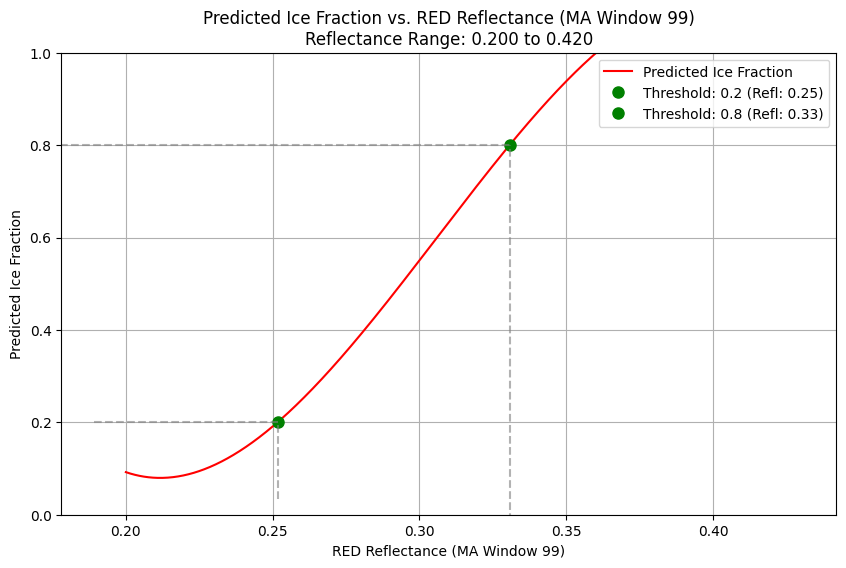


Threshold Summary Table:
Target Ice Fraction  Reflectance     Actual Fraction Difference
0.2                  0.252           0.201           0.0005    
0.8                  0.331           0.801           0.0008    

Threshold results exported to: reflectance_thresholds.csv
Full prediction dataframe exported to: ice_fraction_predictions.csv


In [ ]:
#VISUALIZE PREDICTED ICE FRACTION FROM SPECIFIC MODEL



def create_threshold_plot_adjusted(pred_df, thresholds, best_model):
    """
    Create a plot showing the model prediction with threshold markers using the specified theme.

    Args:
        pred_df (pd.DataFrame): Prediction dataframe
        thresholds (dict): Dictionary of threshold values
        best_model (pd.Series): Best model information
    """
    # Extract model information for dynamic labeling
    model_type = best_model['Model_Type']
    band = best_model['Band']
    win_size = int(best_model['Window_Size'])
    degree = int(best_model['Degree'])

    # Determine filter type for labeling
    filter_type = 'SG' if 'SG' in model_type else 'MA'

    # Create column name for the prediction dataframe to match the theme
    column_name = f'{band} Reflectance ({filter_type} Window {win_size})'

    # Prepare data in the format expected by the visualization theme
    predicted_input_df = pd.DataFrame({
        column_name: pred_df['reflectance'],
        'Predicted Ice Fraction': pred_df['ice_fraction_filtered']
    })

    # Convert thresholds dictionary to match the expected format
    threshold_reflectances = {}
    for target, threshold_info in thresholds.items():
        threshold_reflectances[target] = threshold_info['reflectance']

    # Ensure the predicted_input_df and threshold_reflectances are available
    if not predicted_input_df.empty and threshold_reflectances:

        plt.figure(figsize=(10, 6))

        # Plot the predicted ice fraction curve
        plt.plot(predicted_input_df[column_name], predicted_input_df['Predicted Ice Fraction'],
                 color='red', label='Predicted Ice Fraction')

        # Plot the predicted thresholds as points and add dashed lines
        for threshold, reflectance in threshold_reflectances.items():
            if reflectance is not None:
                # Round reflectance for display
                rounded_reflectance = round(reflectance, 2)
                plt.plot(reflectance, threshold, 'go', markersize=8,
                        label=f'Threshold: {threshold:.1f} (Refl: {rounded_reflectance:.2f})')

                # Add dashed lines to axes
                plt.hlines(threshold, plt.gca().get_xlim()[0], reflectance,
                          linestyle='--', color='gray', alpha=0.6)
                plt.vlines(reflectance, plt.gca().get_ylim()[0], threshold,
                          linestyle='--', color='gray', alpha=0.6)

        # Set axis limits to focus on the relevant range
        x_min, x_max = predicted_input_df[column_name].min(), predicted_input_df[column_name].max()
        margin = (x_max - x_min) * 0.1  # 10% margin
        plt.xlim(x_min - margin, x_max + margin)
        plt.ylim(0, 1)

        plt.title(f'Predicted Ice Fraction vs. {band} Reflectance ({filter_type} Window {win_size})\n'
                  f'Reflectance Range: {x_min:.3f} to {x_max:.3f}')
        plt.xlabel(f'{band} Reflectance ({filter_type} Window {win_size})')
        plt.ylabel('Predicted Ice Fraction')
        plt.legend()
        plt.grid(True)

        # Save the plot AFTER displaying it
        filename = f'threshold_plot_{band.lower()}_{filter_type.lower()}_win{win_size}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Threshold visualization saved as: {filename}")

        plt.show()


        # Return the formatted data for potential further use
        return predicted_input_df, threshold_reflectances

    else:
        print("Predicted data or threshold reflectances not found for visualization.")
        return None, None

# Create the threshold plot if data is available from previous sections
if 'pred_df' in locals() and 'thresholds' in locals() and 'best_model' in locals():
    predicted_input_df, threshold_reflectances = create_threshold_plot_adjusted(pred_df, thresholds, best_model)

    # Display threshold summary table
    print(f"\nThreshold Summary Table:")
    print("="*60)
    print(f"{'Target Ice Fraction':<20} {'Reflectance':<15} {'Actual Fraction':<15} {'Difference':<10}")
    print("="*60)
    for target, info in thresholds.items():
        print(f"{target:<20} {info['reflectance']:<15.3f} {info['actual_fraction']:<15.3f} {info['difference']:<10.4f}")
    print("="*60)

    # Export results to CSV
    export_df = pd.DataFrame({
        'Target_Ice_Fraction': list(thresholds.keys()),
        'Reflectance_Threshold': [info['reflectance'] for info in thresholds.values()],
        'Actual_Ice_Fraction': [info['actual_fraction'] for info in thresholds.values()],
        'Difference': [info['difference'] for info in thresholds.values()]
    })

    export_filename = 'reflectance_thresholds.csv'
    export_df.to_csv(export_filename, index=False)
    print(f"\nThreshold results exported to: {export_filename}")

    # Also export the full prediction dataframe in the new format
    pred_export_filename = 'ice_fraction_predictions.csv'
    if predicted_input_df is not None:
        predicted_input_df.to_csv(pred_export_filename, index=False)
        print(f"Full prediction dataframe exported to: {pred_export_filename}")

else:
    print("Error: Required data not available for threshold visualization")